<a href="https://colab.research.google.com/github/samuelhurni/ML-Cellsegmentation-HSLU-FS24/blob/feature_Dev/ML_Project_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports
import os
import cv2
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim


In [ ]:
#drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_path= '/content/drive/MyDrive/ML_Project/sartorius-cell-instance-segmentation/train'
csv_path='/content/drive/MyDrive/ML_Project/sartorius-cell-instance-segmentation/train.csv'
#test_path= '/content/drive/"My Drive"/name_of_dataset_folder'

annotations = pd.read_csv(csv_path)
print(annotations.head())

             id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2  0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3  0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4  0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   

   height cell_type plate_time sample_date  \
0     520    shsy5y  11h30m00s  2019-06-16   
1     520    shsy5y  11h30m00s  2019-06-16   
2     520    shsy5y  11h30m00s  2019-06-16   
3     520    shsy5y  11h30m00s  2019-06-16   
4     520    shsy5y  11h30m00s  2019-06-16   

                            sample_id elapsed_timedelta  
0  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
2  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
3  shsy5y[diff]_E10-4_Vessel

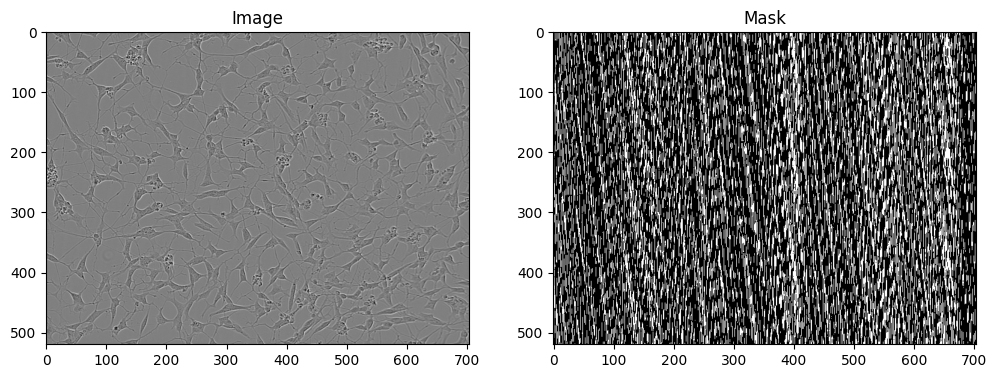

In [ ]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import os

def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    # Ensure that the reshape uses (height, width) not (width, height)
    return img.reshape((shape[0], shape[1]), order='F')

class SartoriusDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations['id'].unique())

    def __getitem__(self, idx):
        unique_ids = self.annotations['id'].unique()
        img_id = unique_ids[idx]
        img_path = os.path.join(self.img_dir, f'{img_id}.png')
        image = cv2.imread(img_path)

        if image is None:
            raise FileNotFoundError(f"No image found at {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = np.zeros((self.annotations.iloc[0]['height'], self.annotations.iloc[0]['width']), dtype=np.uint8)

        img_annotations = self.annotations[self.annotations['id'] == img_id]
        for _, ann in img_annotations.iterrows():
            rle = ann['annotation']
            shape = (ann['height'], ann['width'])
            decoded_mask = rle_decode(rle, shape)
            # Ensure both masks are the same shape before using np.maximum
            if mask.shape != decoded_mask.shape:
                raise ValueError(f"Mask shape {mask.shape} and decoded mask shape {decoded_mask.shape} do not match")
            mask = np.maximum(mask, decoded_mask)

        if self.transform:
            result = self.transform(image=image, mask=mask)
            image = result['image']
            mask = result['mask']

        return image, mask


# Assuming 'annotations' is your DataFrame and 'train_path' is the directory where your images are stored


dataset = SartoriusDataset(annotations, train_path)
image, mask = dataset[0]  # Get the first sample

# Visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool followed by double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [ ]:
# Example using a dummy input to check the model's output shape
unet = UNet(n_channels=3, n_classes=1)  # Assuming RGB images, and binary mask output
dummy_input = torch.rand(1, 3, 520, 704)  # Batch size of 1, 3 channels, dimensions 520x704
dummy_output = unet(dummy_input)
print(f"Output shape: {dummy_output.shape}")  # Should be [1, 1, 520, 704] for binary segmentation


Output shape: torch.Size([1, 1, 520, 704])


In [ ]:
import torch.optim as optim
import torch.nn as nn

# Example setup for binary cross-entropy loss with logits (combines sigmoid with BCE loss)
criterion = nn.BCEWithLogitsLoss()

# Set up the optimizer
optimizer = optim.Adam(unet.parameters(), lr=0.001)

# Example training loop for one batch (not a full training routine)
optimizer.zero_grad()
outputs = unet(dummy_input)
loss = criterion(outputs, torch.rand(1, 1, 520, 704))  # Dummy target for demonstration
loss.backward()
optimizer.step()

print(f"Sample loss: {loss.item()}")


Sample loss: 0.7098079919815063


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

def train_one_epoch(model, dataloader, criterion, optimizer, device, accumulation_steps=4):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()
    for i, (images, masks) in enumerate(tqdm(dataloader, desc="Training", leave=False)):
        images = images.to(device).float().permute(0, 3, 1, 2) / 255.0
        masks = masks.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, masks) / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * accumulation_steps

    return running_loss / len(dataloader.dataset)






# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

total_size = len(dataset)
val_size = int(0.1 * total_size)  # 10% for validation
train_size = total_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)



In [ ]:
train_one_epoch(model, train_loader, criterion, optimizer, device)


0.1250835528849682

In [ ]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation", leave=False):
            images = images.to(device).float().permute(0, 3, 1, 2) / 255.0  # Ensure correct shape and normalization
            masks = masks.to(device).float().unsqueeze(1)  # Add the channel dimension

            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)


In [ ]:
validate(model, val_loader, criterion, device )

0.391000368197759

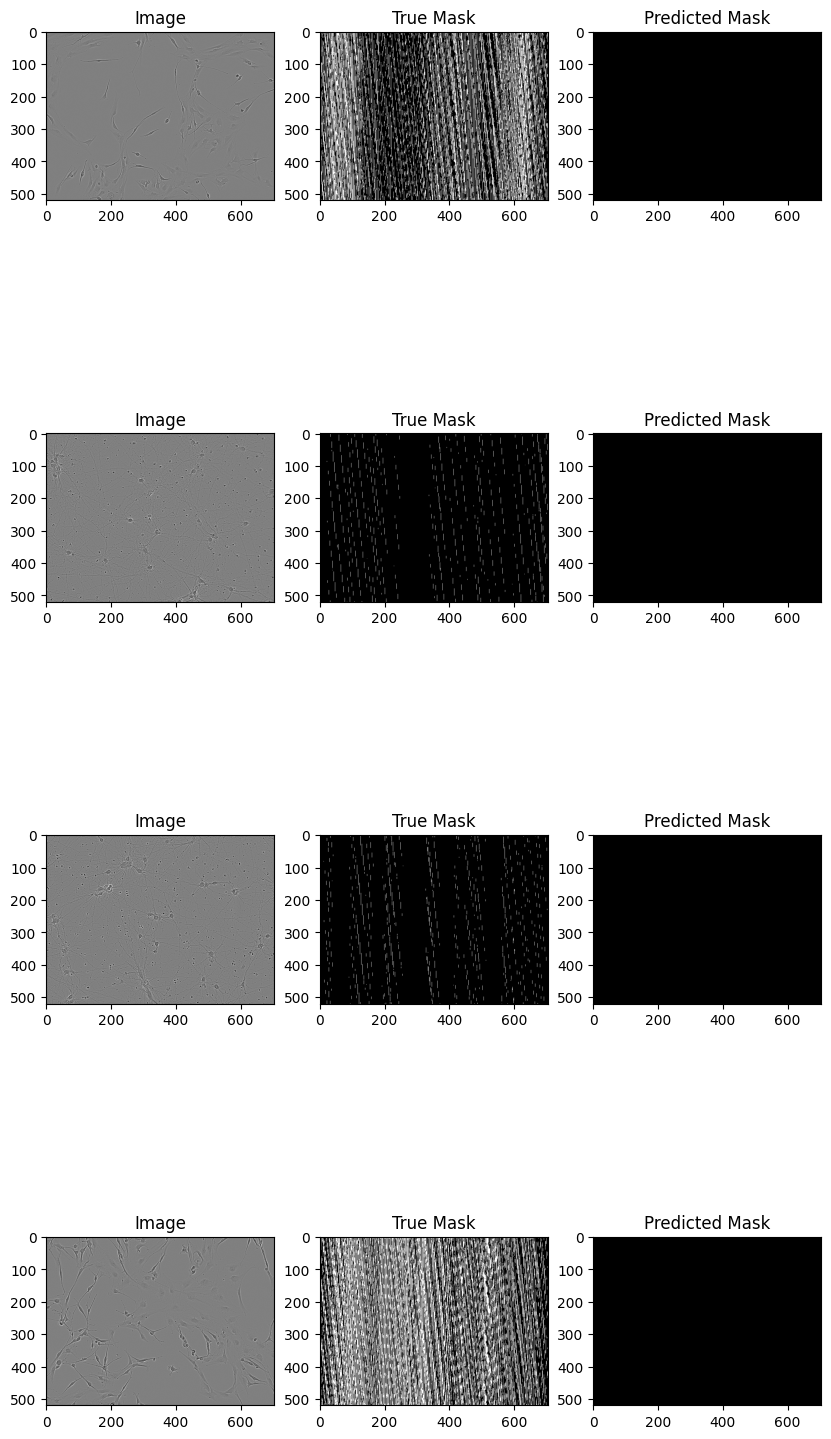

In [ ]:
def visualize_predictions(data_loader, model, device, num_batches=1):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(data_loader):
            if i >= num_batches:
                break
            images = images.to(device).float().permute(0, 3, 1, 2) / 255.0
            masks = masks.to(device).float().unsqueeze(1)
            preds = torch.sigmoid(model(images))
            preds = preds > 0.5  # Thresholding prediction
            fig, ax = plt.subplots(nrows=images.size(0), ncols=3, figsize=(10, 5*images.size(0)))
            for j in range(images.size(0)):
                ax[j, 0].imshow(images[j].cpu().permute(1, 2, 0))
                ax[j, 0].set_title("Image")
                ax[j, 1].imshow(masks[j].cpu().squeeze(), cmap='gray')
                ax[j, 1].set_title("True Mask")
                ax[j, 2].imshow(preds[j].cpu().squeeze(), cmap='gray')
                ax[j, 2].set_title("Predicted Mask")
            plt.show()

visualize_predictions(val_loader, model, device)


Epoch 1/10 - Training Loss: 0.0907, Validation Loss: 0.3507
Saved Best Model


Epoch 2/10 - Training Loss: 0.0846, Validation Loss: 0.3306
Saved Best Model


Epoch 3/10 - Training Loss: 0.0808, Validation Loss: 0.3230
Saved Best Model


Epoch 4/10 - Training Loss: 0.0792, Validation Loss: 0.2963
Saved Best Model


Epoch 5/10 - Training Loss: 0.0766, Validation Loss: 0.2984


Epoch 6/10 - Training Loss: 0.0772, Validation Loss: 0.2964


Epoch 7/10 - Training Loss: 0.0773, Validation Loss: 0.3032


Epoch 8/10 - Training Loss: 0.0761, Validation Loss: 0.2943
Saved Best Model


Epoch 9/10 - Training Loss: 0.0756, Validation Loss: 0.3025


Epoch 10/10 - Training Loss: 0.0762, Validation Loss: 0.3021


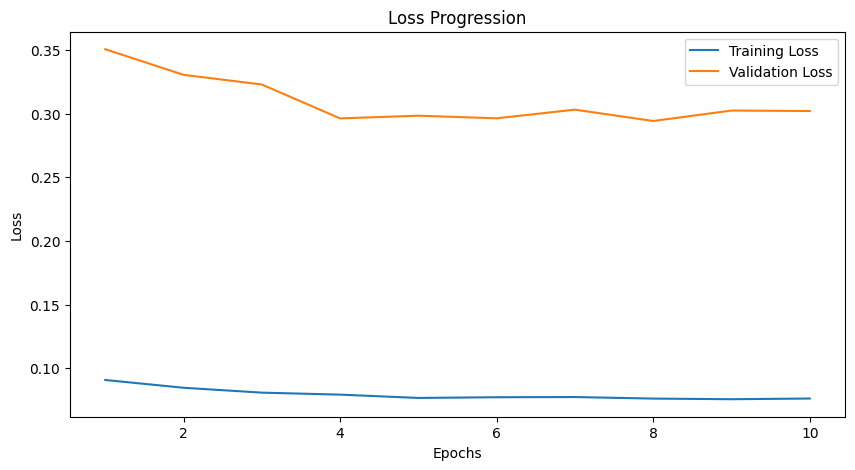

In [ ]:
num_epochs = 10
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)

    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Save the model if it's the best so far
    if val_loss == min(validation_losses):
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved Best Model")

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Progression')
plt.legend()
plt.show()
